In [1]:
import requests

import re
import yaml
import json
import gmaps
import holidays
import numpy as np
import pandas as pd
from time import sleep
from tqdm import tqdm
from datetime import time
from datetime import date
from datetime import datetime
from datetime import timedelta

from scraper.Parser import Gesucht

import matplotlib.pyplot as plt 

from bson.objectid import ObjectId
from scraper.mongo_handler import Mongo
from scraper.VBB import VBB
from scraper.utilities import coordinate_distance

In [9]:
plt.style.use('ggplot')
pd.set_option('display.max_colwidth', -1)
plt.rcParams['figure.figsize'] = (16.0, 8.0)

In [2]:
city = 'berlin'

with open('scraper/config/{city}.yaml'.format(city=city)) as f:
    config = yaml.load(f)

gmaps.configure(api_key=config['google_api_key'])

gesucht = Gesucht(config)
mongo = Mongo(config['mongo'])

center = {'hamburg': (53.553077, 10.006572), 'berlin': (52.525789, 13.369574)}

In [3]:
gen_time = datetime.today() - timedelta(days=2, hours=0, minutes=0) 
existing = list(mongo.db['travel_routes'].find({"_id": {"$gte": ObjectId.from_datetime(gen_time)}}))

In [4]:
fields = {'_id': 1, 'name': 1, 'lat': 1, 'lng': 1, 'user_id': 1}

destinations = list(mongo.db['destinations'].find({}, fields))
destinations = pd.DataFrame(destinations)

destinations

,_id,lat,lng,name
0,5c549310b451ea2c01605bab,52.511794,13.291066,charlottenburg
1,5c549310b451ea2c01605bac,52.457048,13.688608,friedrichshagen
2,5c549310b451ea2c01605bad,52.513812,13.458979,friedrichshain
3,5c549310b451ea2c01605bae,52.531368,13.588181,hellersdorf
4,5c549310b451ea2c01605baf,52.580827,13.511707,hohenschoenhausen
5,5c549310b451ea2c01605bb0,52.436953,13.564079,koepenick
6,5c549310b451ea2c01605bb1,52.497732,13.412660,kreuzberg
7,5c549310b451ea2c01605bb2,52.512448,13.496320,lichtenberg
8,5c549310b451ea2c01605bb3,52.518113,13.330475,moabit
9,5c549310b451ea2c01605bb4,52.467910,13.445895,neukoelln


In [5]:
fig = gmaps.figure()
colors = [tuple(np.random.randint(0, 256) for _ in range(3)) for _ in destinations.iterrows()]


destination_layer = gmaps.symbol_layer(destinations[['lat', 'lng']], 
                                       scale=3,
                                       fill_color=colors,
                                       stroke_color=colors,
                                       info_box_content=destinations.name)
fig.add_layer(destination_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [ ]:
def parse(travel_route):
    
    # get mongo _id for each location
    origin = travel_route['origin']['_id']
    destination = travel_route['destination']['_id']

    # put routes in data frame
    df = pd.DataFrame(travel_route['routes'])
    
    # calculate an outlier-cutoff based on VBB routes 
    # from the origin to the destination
    vbb_times = df[df.source == 'vbb'].groupby('bike_required').duration
    vbb_times = vbb_times.mean() + 3*vbb_times.std()
    
    # get times for heuristic "estimates" of biking/walking
    estimate_times = df[df.source == 'estimate'].groupby('bike_required').duration.min()

    # subset time calculations in case of missing routes
    shared_index = set(vbb_times.index).intersection(estimate_times.index)
    estimate_times = estimate_times[estimate_times.index.isin(shared_index)]
    vbb_times = vbb_times[vbb_times.index.isin(shared_index)]
    
    if len(vbb_times) and len(estimate_times):
        drop = (estimate_times <= vbb_times).compress(lambda p: p == False)
        estimates = df[(df.source == 'estimate')]
        estimates_to_drop = estimates[estimates.bike_required.isin(drop.index)]
        df = df.drop(estimates_to_drop.index)

    return df

In [ ]:
if False:
    
    docs = []

    for routes in tqdm(existing):
        
        docs = []
        df = parse(routes)


        origin = routes['origin']
        dest = routes['destination']

        for bike_available in [True, False]:

            if not bike_available:
                df = df[df.bike_required == False]


            docs.append( {'origin': origin['_id'], 
                          'destination': dest['_id'],
                          'bike_available': bike_available,
                          'mean_duration': df.duration.mean(),
                          'min_duration': df.duration.min(), 
                          'max_duration': df.duration.max(), 
                          'n_routes': df.duration.count(), 
                          'duration_std': df.duration.std()})
            
        #mongo.db['travel_times'].insert_one(docs.to_dict('records'))
            
    docs = pd.DataFrame(docs)

In [ ]:
#mongo.db['travel_times'].insert_many(docs.to_dict('records'))

In [6]:
has_bike = True

travel_times = list(mongo.db['travel_times'].find({'bike_available': has_bike}))
travel_times = pd.DataFrame(travel_times)

travel_times.head()

,_id,bike_available,destination,duration_std,max_duration,mean_duration,min_duration,n_routes,origin
0,5c798a66b451ea42bbe09c5b,True,5c549310b451ea2c01605bab,27.577164,55,35.5,16,2,5c76f84562c5780bee0f9416
1,5c798a66b451ea42bbe09c5d,True,5c549310b451ea2c01605bac,248.901587,503,327.0,151,2,5c76f84562c5780bee0f9416
2,5c798a66b451ea42bbe09c5f,True,5c549310b451ea2c01605bad,89.802561,181,117.5,54,2,5c76f84562c5780bee0f9416
3,5c798a66b451ea42bbe09c61,True,5c549310b451ea2c01605bae,176.069589,355,230.5,106,2,5c76f84562c5780bee0f9416
4,5c798a66b451ea42bbe09c63,True,5c549310b451ea2c01605baf,130.107648,262,170.0,78,2,5c76f84562c5780bee0f9416


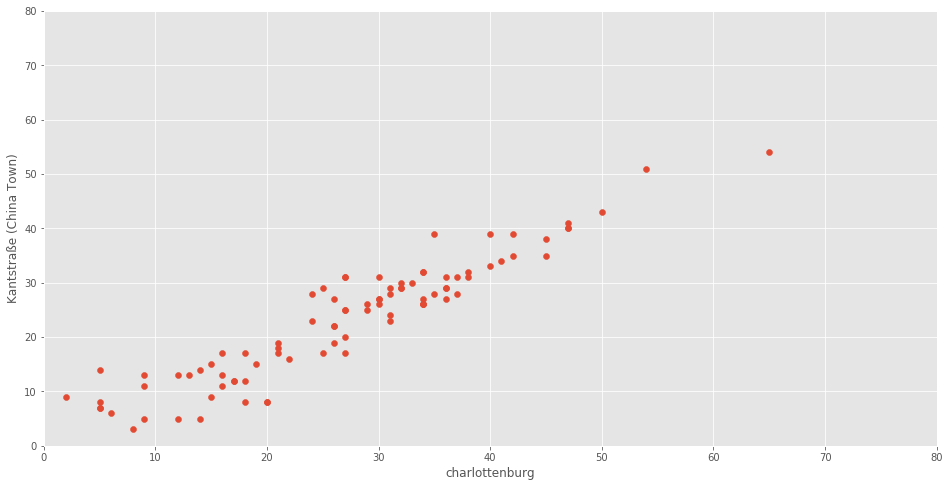

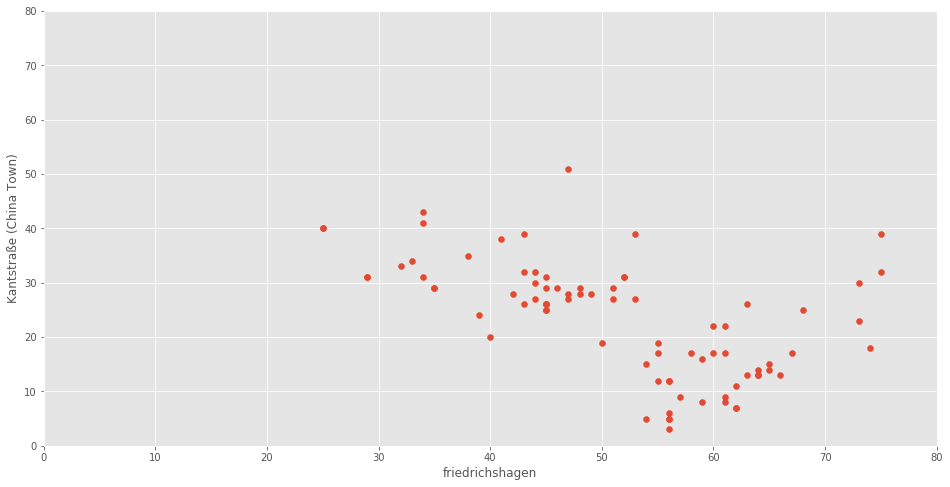

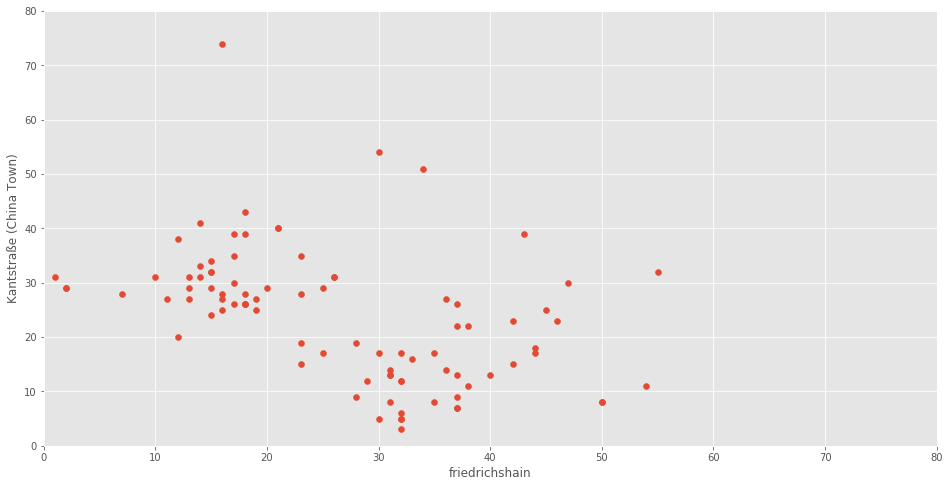

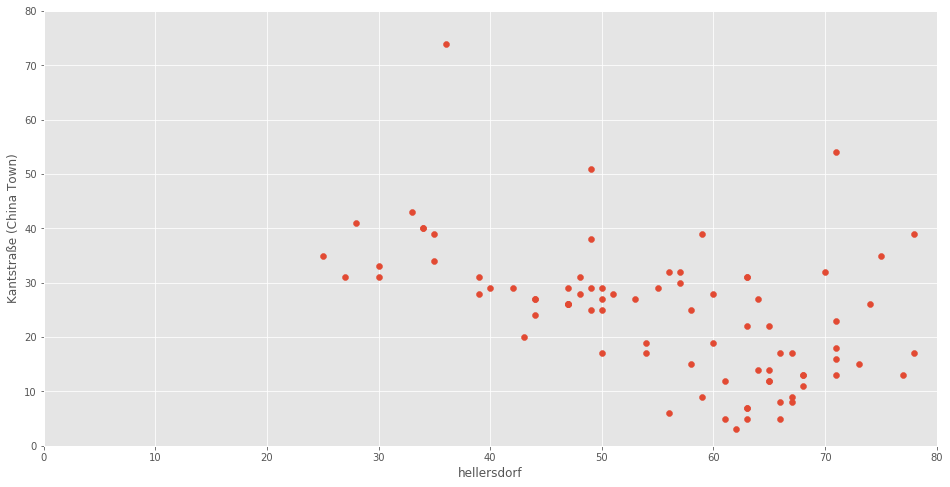

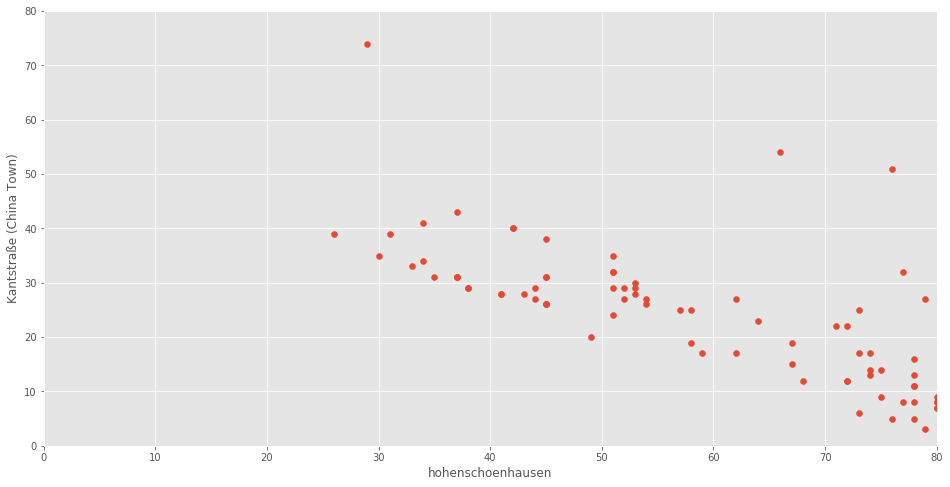

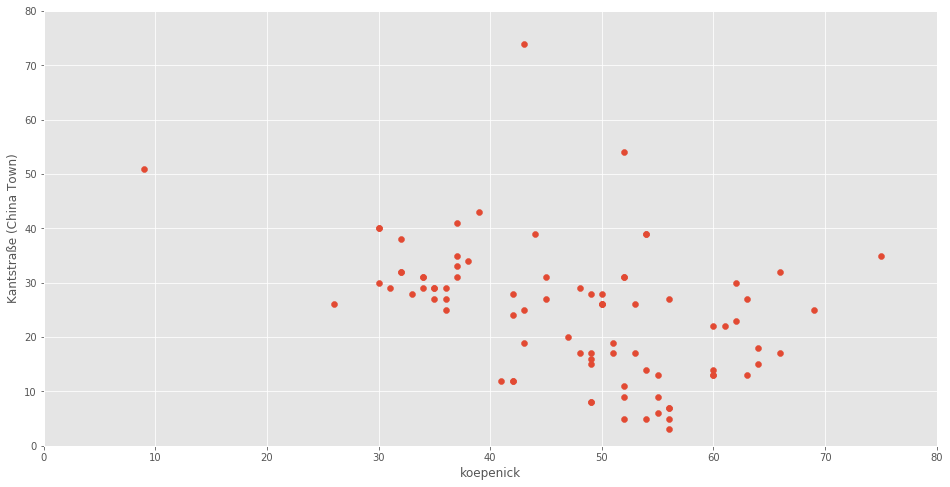

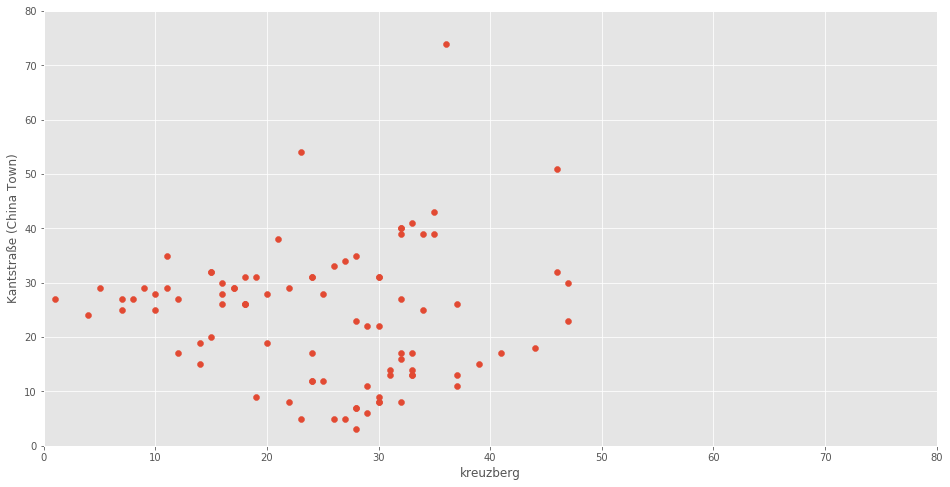

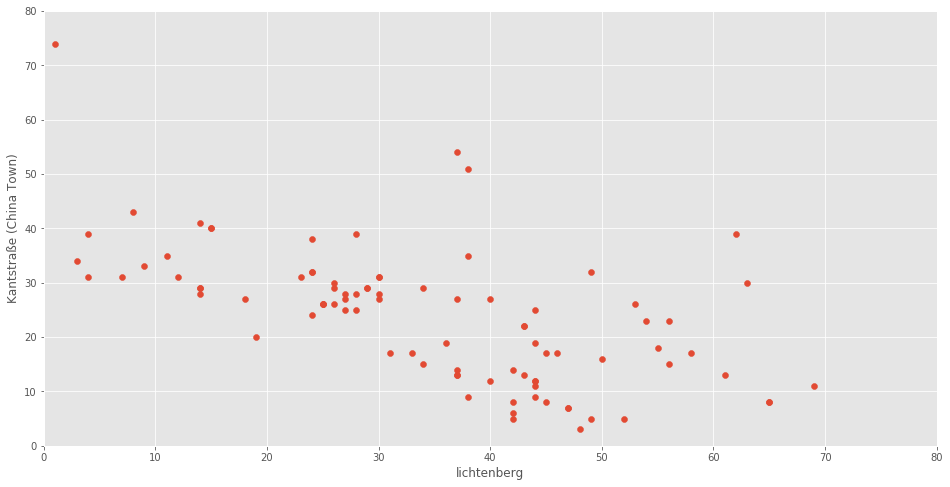

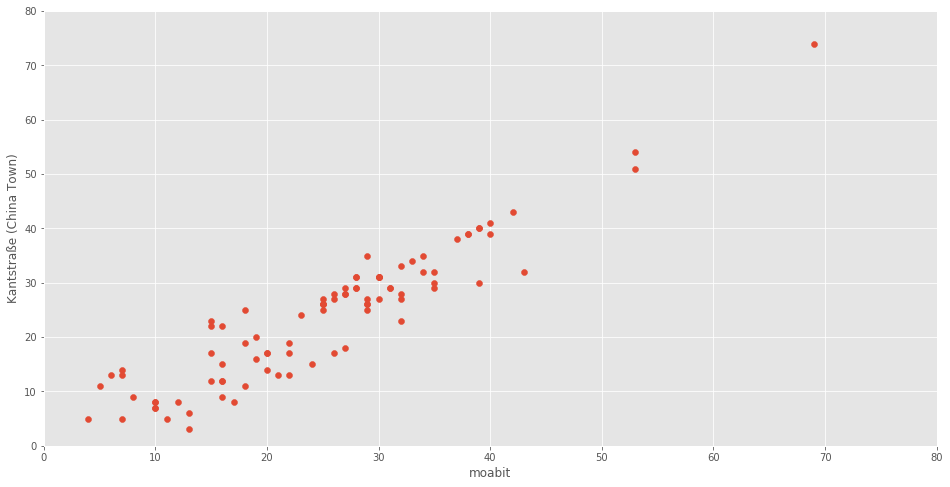

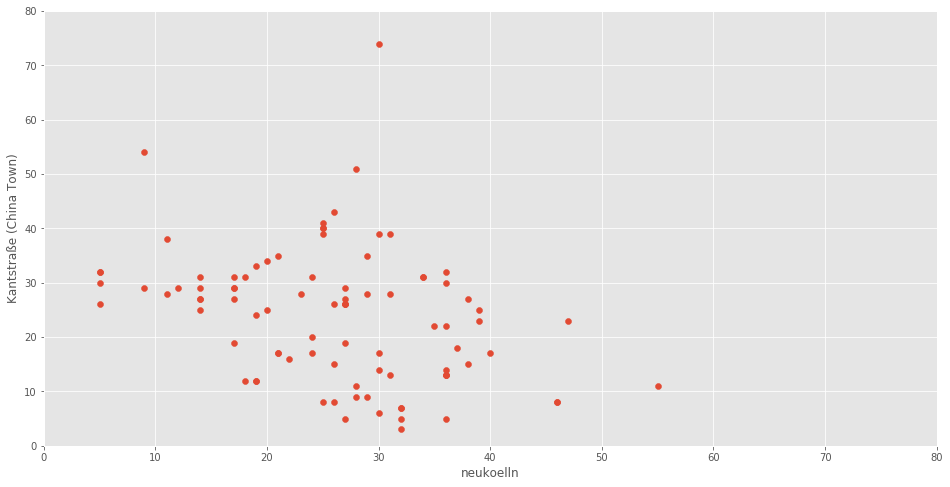

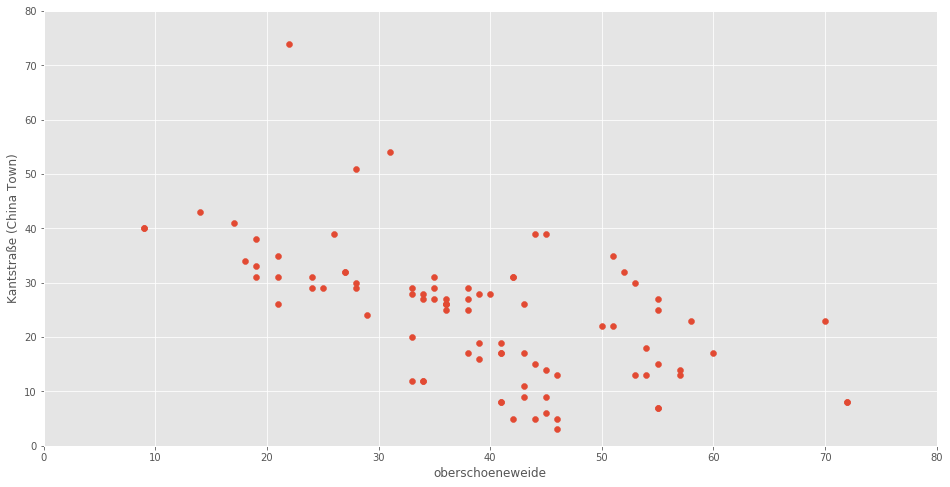

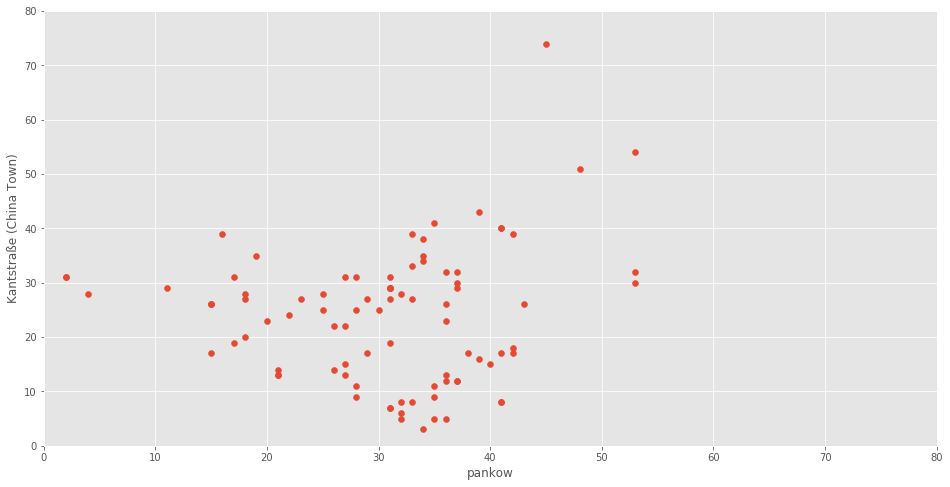

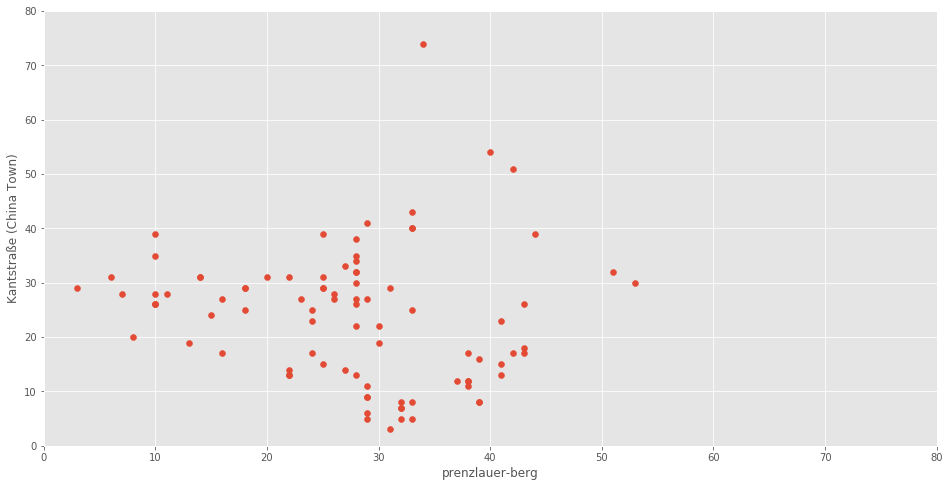

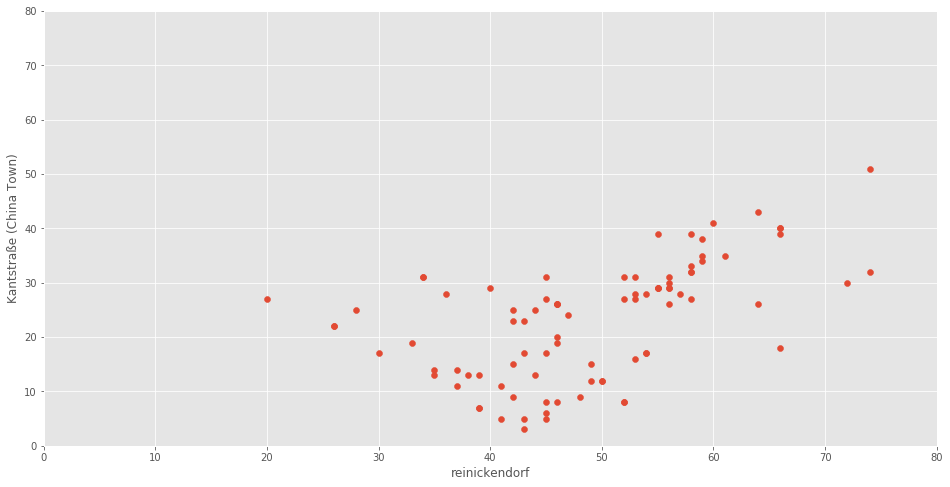

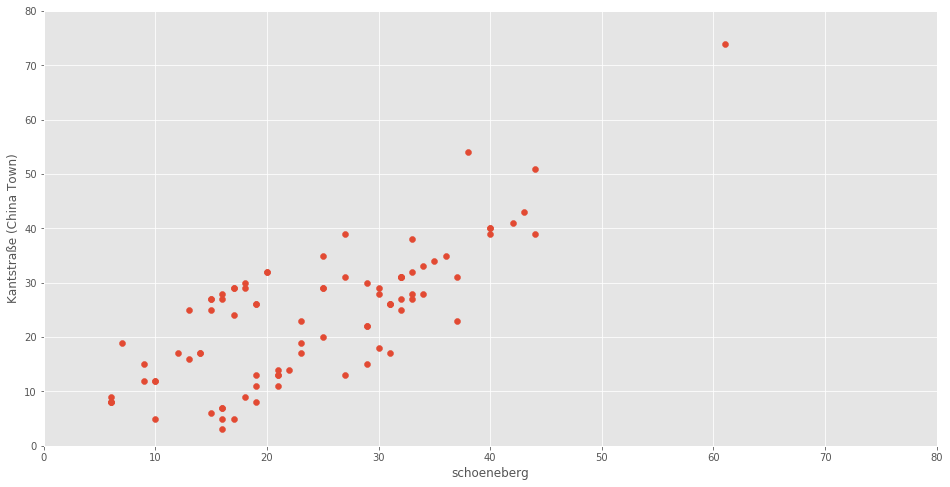

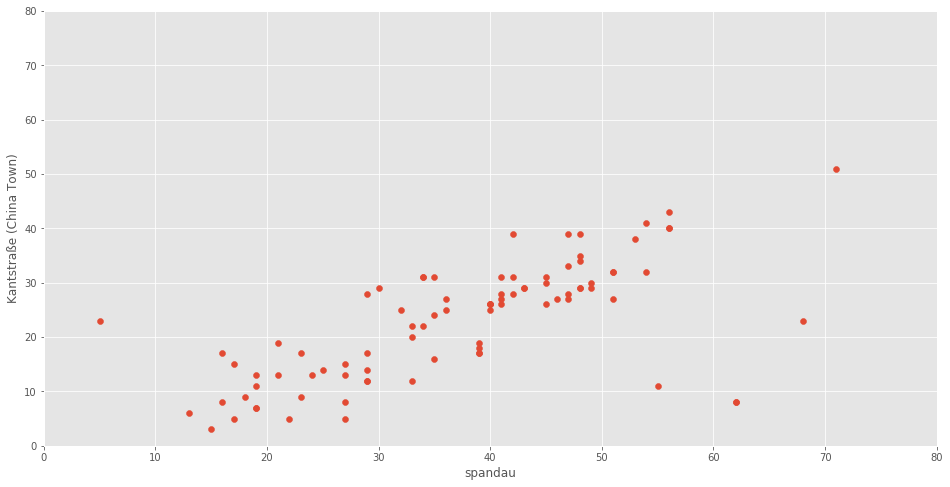

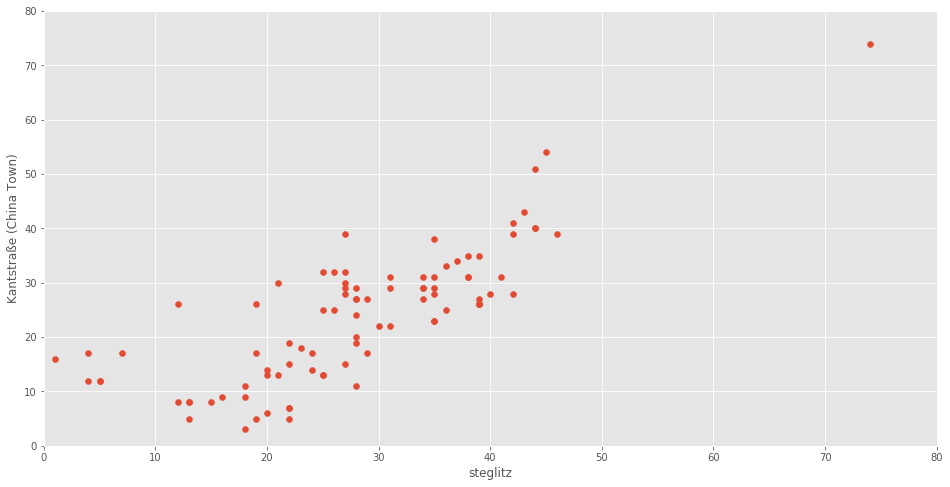

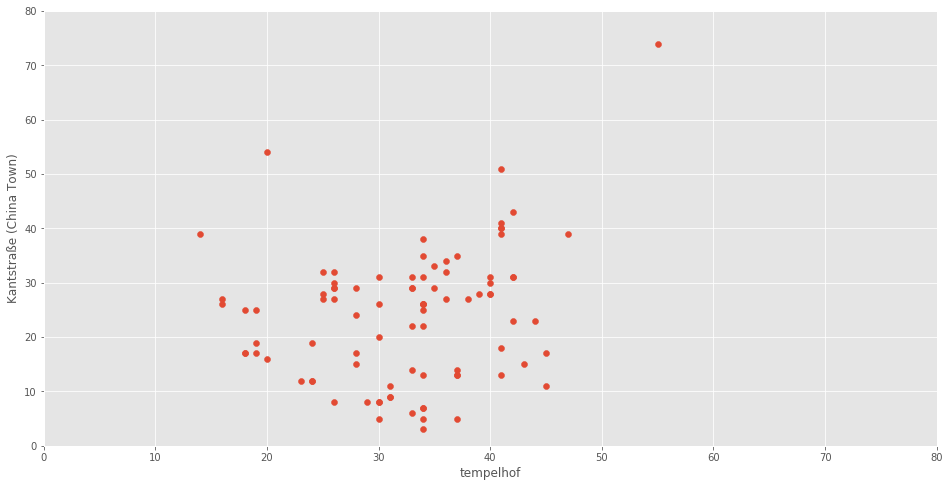

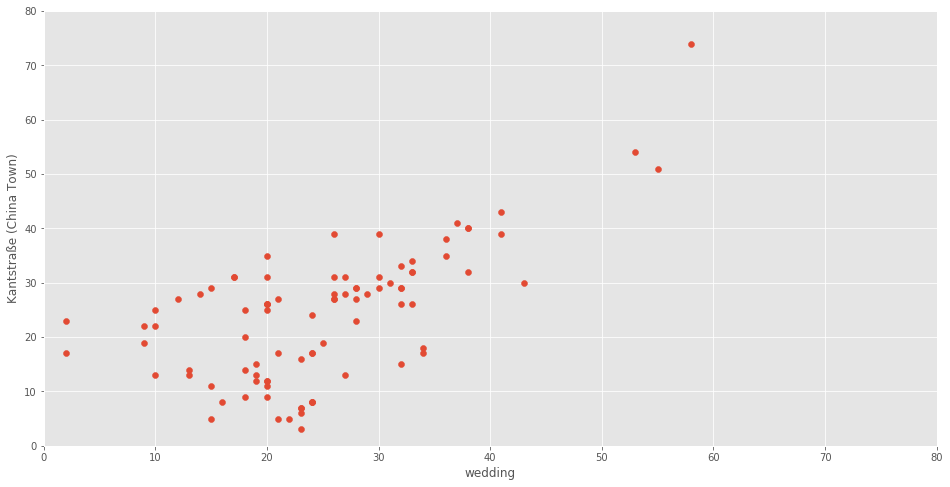

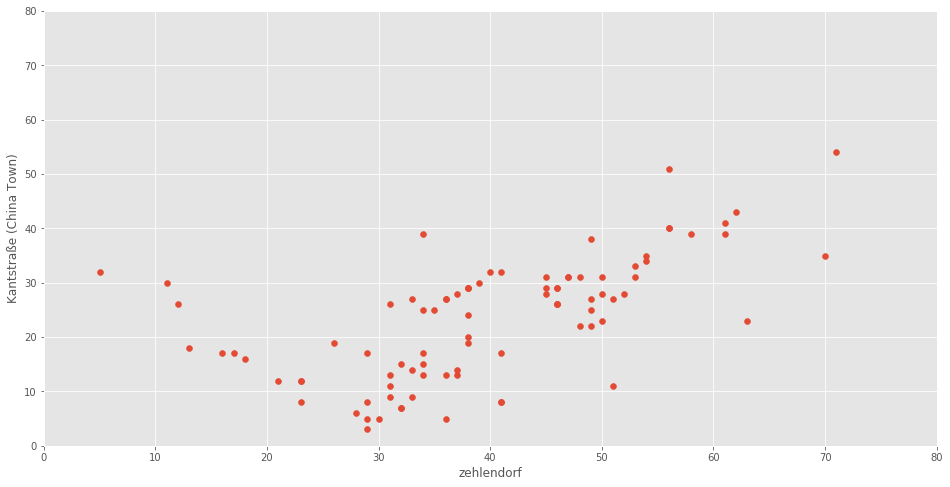

In [10]:
for d in destinations.name:
    if d == 'Kantstraße (China Town)':
        continue
        
    data = {}

    dests = destinations[destinations.name.isin(['Kantstraße (China Town)', d])]

    for _, dest in dests.iterrows():

        times = travel_times[travel_times.destination == dest._id]
        data[dest['name']] = times.groupby('origin').min_duration.mean()
    
    
    keys = list(data.keys())
    x = keys[0]
    y = keys[1]
    plt.scatter(data[x], data[y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.xlim([0, 80])
    plt.ylim([0, 80])
    plt.show()


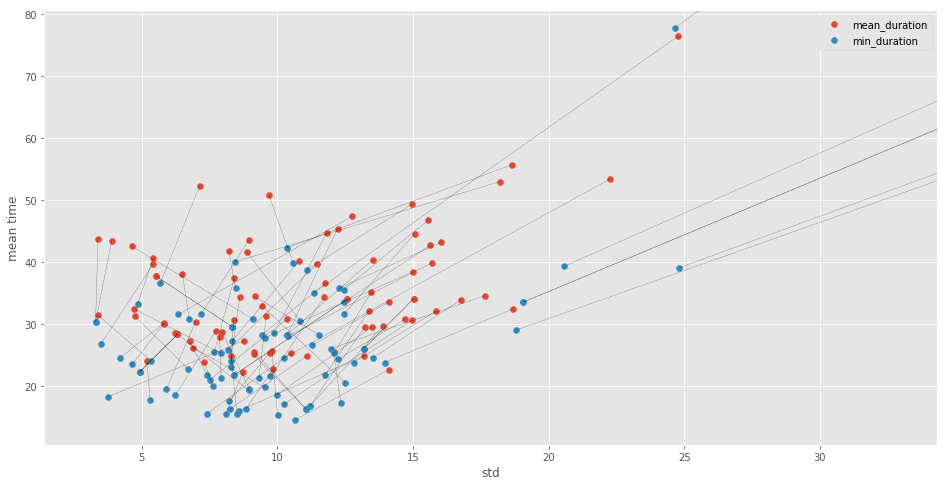

In [42]:
cache = {}

user_destinations = ['Kantstraße (China Town)', 'kreuzberg', 'friedrichshain', 'neukoelln'] # 'neukoelln', 'friedrichshain'
user_destinations = destinations[destinations.name.isin(user_destinations)]

relevant_times = travel_times[travel_times.destination.isin(user_destinations['_id'])]
    
metrics = ['mean_duration', 'min_duration']
for metric in metrics:


    stds = relevant_times.groupby('origin')[metric].std()
    means = relevant_times.groupby('origin')[metric].mean()

    plt.scatter(stds, means, label=metric)
    plt.xlabel('std')
    plt.ylabel('mean time'.format(metric=metric));
    
    cache[metric] = (stds, means)
    

a = cache[metrics[0]]
b = cache[metrics[1]]

x = [a[0], b[0]]
y = [a[1], b[1]]
plt.plot(x, y, 'k--', linewidth=0.25)


x = np.array(x)
y = np.array(y)

plt.xlim([x.min() - 0.25*x.std(), x.mean() + 3*x.std()])
plt.ylim([y.min() - 0.25*y.std(), y.mean() + 3*y.std()])

plt.legend()


In [47]:
user_destinations = ['Kantstraße (China Town)','kreuzberg'] #
user_destinations = destinations[destinations.name.isin(user_destinations)]
relevant_times = travel_times[travel_times.destination.isin(user_destinations['_id'])]
relevant_times_mean = relevant_times.groupby('origin').mean().reset_index()

In [53]:
fields = {'_id': 1, 'url': 1, 'lat': 1, 'rent':1, 'square_meters': 1, 'lng': 1,}

origins = list(mongo.db['berlin'].find({'_id': {'$in': list(relevant_times.origin)}}, fields))
origins = pd.DataFrame(origins)
origins = origins.rename(columns={'_id': 'origin'})
origins = origins.merge(relevant_times_mean, on='origin')
origins = origins.sort_values(by=['min_duration', 'rent', 'square_meters'], ascending=[True, False, True])

In [54]:
fig = gmaps.figure()
colors = [tuple(np.random.randint(0, 256) for _ in range(3)) for _ in user_destinations.iterrows()]

n = 25
destination_layer = gmaps.symbol_layer(user_destinations[['lat', 'lng']], 
                                       scale=8,
                                       fill_color=colors,
                                       stroke_color=colors,
                                       info_box_content=list(user_destinations.name))
fig.add_layer(destination_layer)

origin_layer = gmaps.symbol_layer(origins.iloc[0:n][['lat', 'lng']],
                                  scale=3, 
                                  info_box_content=list(origins.url)[0:n])
fig.add_layer(origin_layer)

fig

Figure(layout=FigureLayout(height='420px'))